# **Tweet Sentiment Extraction**

Extract support phrases for sentiment labels.

> [**Kaggle Dataset**](https://www.kaggle.com/c/tweet-sentiment-extraction/data)

> [**TF RoBERTa Credentials**](https://www.kaggle.com/cdeotte/tf-roberta)

> [**Reference Notebook**](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705)

In [ ]:
# Install Kaggle.
!pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
# Files Upload.
from google.colab import files

files.upload()

In [ ]:
# Create a Kaggle Folder.
!mkdir ~/.kaggle

# Copy the kaggle.json to the folder created.
!cp kaggle.json ~/.kaggle/

# Permission for the json file to act.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Dataset Download.
!kaggle competitions download -c tweet-sentiment-extraction
!kaggle datasets download -d cdeotte/tf-roberta

In [ ]:
# Unzip Dataset.
!unzip tweet-sentiment-extraction.zip
!unzip tf-roberta.zip

# **Project Initialization.**

In [ ]:
!pip install transformers

In [7]:
# Import Library.
import pandas as pd
import numpy as np
import re, string, nltk, tokenizers
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = "retina"
sns.set()

import tensorflow as tf
import tensorflow.keras.backend as K
from transformers import TFRobertaModel, RobertaConfig
from wordcloud import WordCloud
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [8]:
# Load Dataset.
train = pd.read_csv("train.csv").fillna("")
test = pd.read_csv("test.csv").fillna("")
submission = pd.read_csv("sample_submission.csv")

train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


# **Exploratory Data Analysis.**

*Exploratory Data Analysis (EDA) is an approach to analyze the data using visual techniques. It is used to discover trends, patterns, or to check assumptions with the help of statistical summary and graphical representations.*

In [9]:
# Dataset Shapes.
print(train.shape, test.shape)

(27481, 4) (3534, 3)


In [10]:
# Distribution of tweets in the Training Set.
count = (
    train.groupby("sentiment")
    .count()["text"]
    .reset_index()
    .sort_values(by="text", ascending=False)
)
count.style.background_gradient(cmap="Purples")

,sentiment,text
1,neutral,11118
2,positive,8582
0,negative,7781


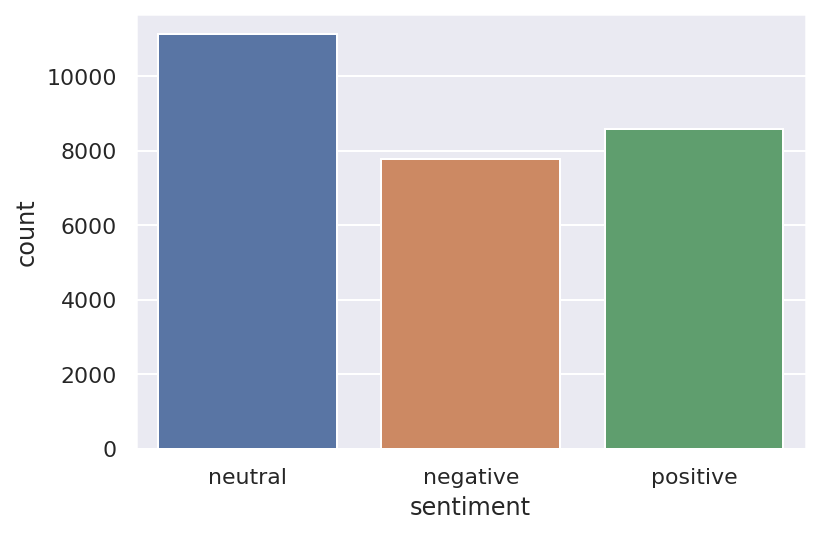

In [11]:
# Distribution Plot of tweets in the Training Set.
plt.figure(figsize=(6, 4))
sns.countplot(x="sentiment", data=train)

Length of Shortest Text = 0
Length of Longest Text = 141 



Text(0, 0.5, 'Density')

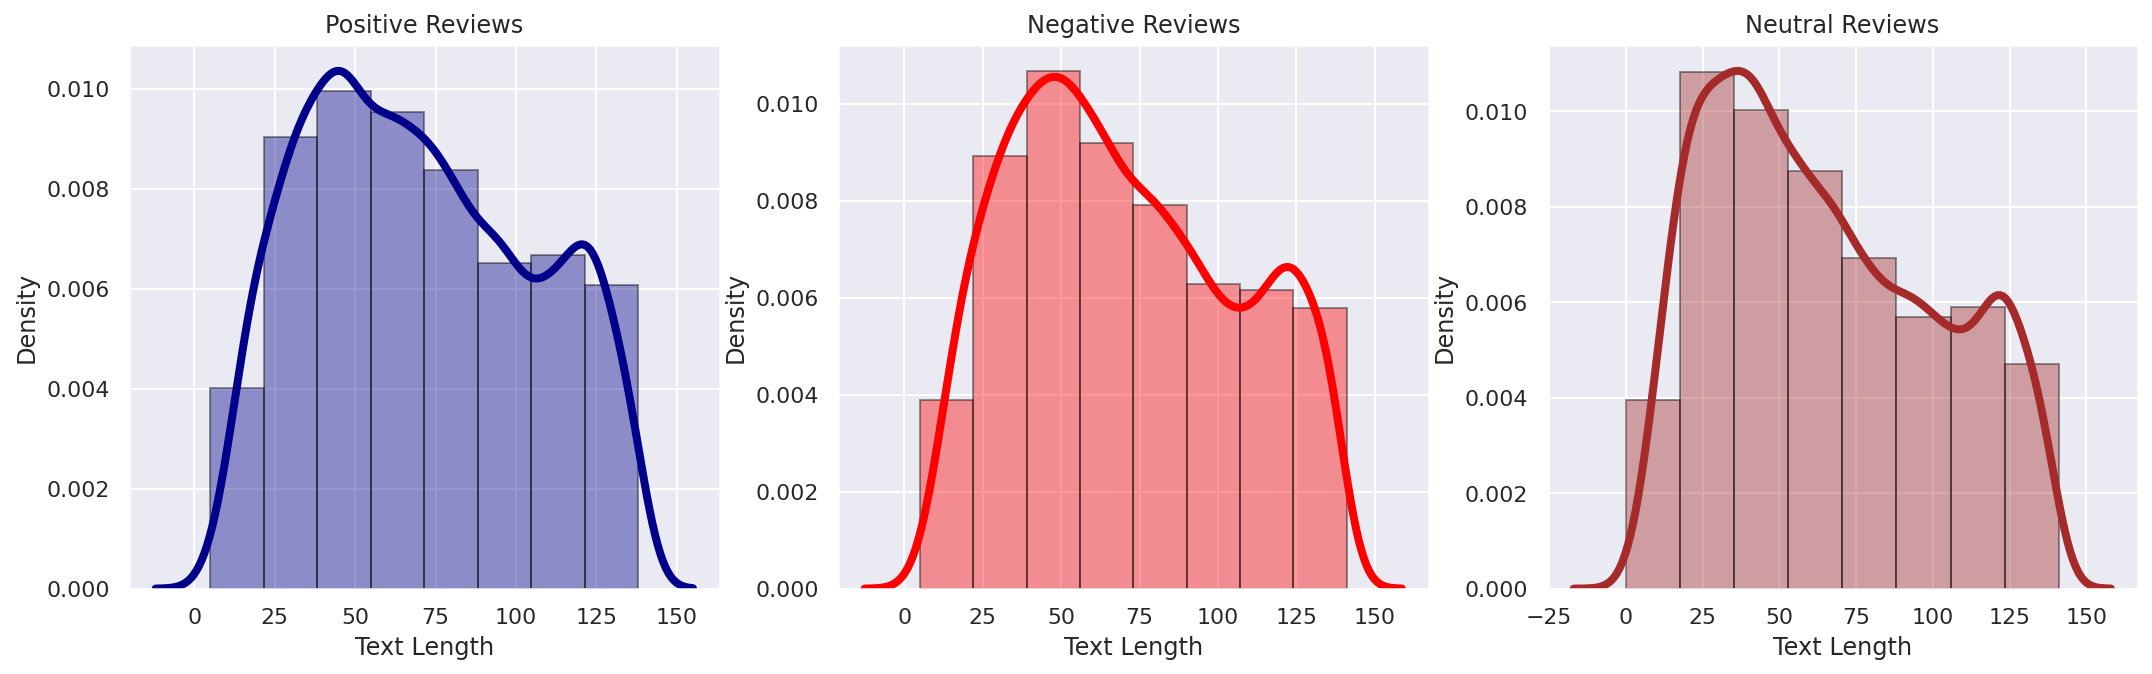

In [12]:
""" Analysis of Text Length. """

print("Length of Shortest Text =", min(train["text"].str.len()))
print("Length of Longest Text =", max(train["text"].str.len()), "\n")

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# For Positive Review.
sns.distplot(
    train[train["sentiment"] == "positive"]["text"].str.len(),
    hist=True,
    kde=True,
    ax=ax1,
    bins=int(200 / 25),
    color="darkblue",
    hist_kws={"edgecolor": "black"},
    kde_kws={"linewidth": 4},
)

ax1.set_title("Positive Reviews")
ax1.set_xlabel("Text Length")
ax1.set_ylabel("Density")

# For Negative Review.
sns.distplot(
    train[train["sentiment"] == "negative"]["text"].str.len(),
    hist=True,
    kde=True,
    ax=ax2,
    bins=int(200 / 25),
    color="red",
    hist_kws={"edgecolor": "black"},
    kde_kws={"linewidth": 4},
)

ax2.set_title("Negative Reviews")
ax2.set_xlabel("Text Length")
ax2.set_ylabel("Density")

# For Neutral Review.
sns.distplot(
    train[train["sentiment"] == "neutral"]["text"].str.len(),
    hist=True,
    kde=True,
    ax=ax3,
    bins=int(200 / 25),
    color="brown",
    hist_kws={"edgecolor": "black"},
    kde_kws={"linewidth": 4},
)

ax3.set_title("Neutral Reviews")
ax3.set_xlabel("Text Length")
ax3.set_ylabel("Density")

In [13]:
""" Central Tendency Analysis. """


def text_length(target, feature):
    mean = np.mean(train[train["sentiment"] == target][feature].str.len())
    median = np.median(train[train["sentiment"] == target][feature].str.len())
    return np.round_(mean, decimals=2), np.round_(median, decimals=2)


# Text Length for Positive Review.
print(
    "Mean and Median length for the Positive review 'text' feature is",
    text_length("positive", "text")[0],
    "and",
    text_length("positive", "text")[1],
    "respectively.",
)

print(
    "Mean and Median length for the Positive review 'selected_text' feature is",
    text_length("positive", "selected_text")[0],
    "and",
    text_length("positive", "selected_text")[1],
    "respectively.",
)

# Text Length for Negative Review.
print(
    "\nMean and Median length for the Negative review 'text' feature is",
    text_length("negative", "text")[0],
    "and",
    text_length("negative", "text")[1],
    "respectively.",
)

print(
    "Mean and Median length for the Negative review 'selected_text' feature is",
    text_length("negative", "selected_text")[0],
    "and",
    text_length("negative", "selected_text")[1],
    "respectively.",
)

# Text Length for Neutral Review.
print(
    "\nMean and Median length for the Neutral review 'text' feature is",
    text_length("neutral", "text")[0],
    "and",
    text_length("neutral", "text")[1],
    "respectively.",
)

print(
    "Mean and Median length for the Neutral review 'selected_text' feature is",
    text_length("neutral", "selected_text")[0],
    "and",
    text_length("neutral", "selected_text")[1],
    "respectively.",
)

Mean and Median length for the Positive review 'text' feature is 70.42 and 67.0 respectively.
Mean and Median length for the Positive review 'selected_text' feature is 18.12 and 10.0 respectively.

Mean and Median length for the Negative review 'text' feature is 70.49 and 66.0 respectively.
Mean and Median length for the Negative review 'selected_text' feature is 19.97 and 12.0 respectively.

Mean and Median length for the Neutral review 'text' feature is 65.2 and 59.0 respectively.
Mean and Median length for the Neutral review 'selected_text' feature is 62.76 and 57.0 respectively.


In [14]:
""" Word Cloud Analysis Helper Functions. """

def create_corpus(target, feature):
    corpus = []
    for x in train[train["sentiment"] == target][feature].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def plot_wordcloud(corpus):
    plt.figure(figsize=(14, 5))
    word_cloud = WordCloud(background_color="black", max_font_size=60).generate(" ".join(corpus[:50]))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

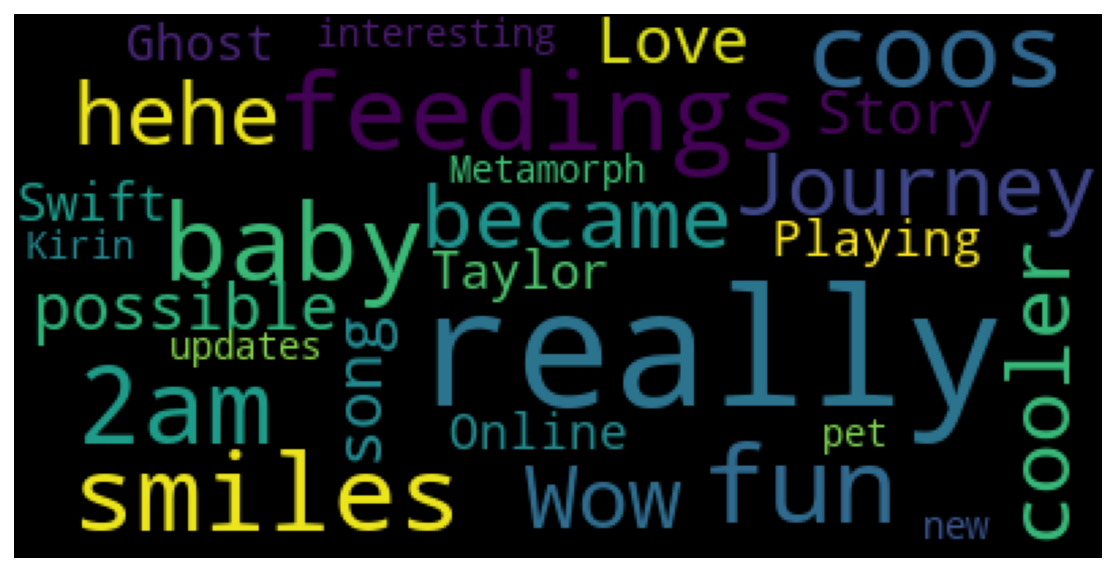

In [15]:
# Generate the Word Cloud for Positive Sentiment.
plot_wordcloud(create_corpus("positive", "text"))

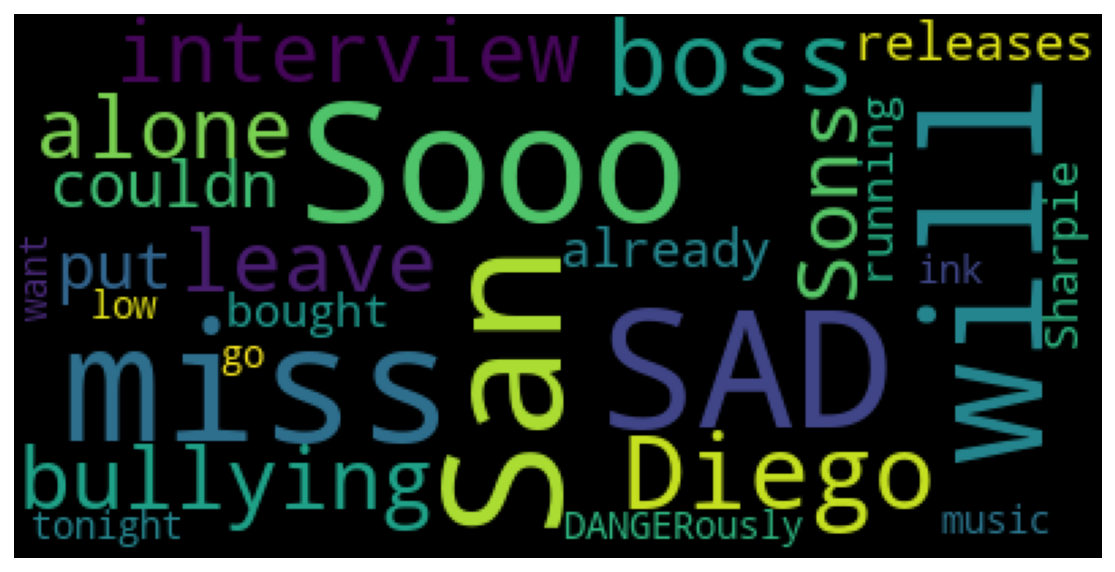

In [16]:
# Generate the Word Cloud for Negative Sentiment.
plot_wordcloud(create_corpus("negative", "text"))

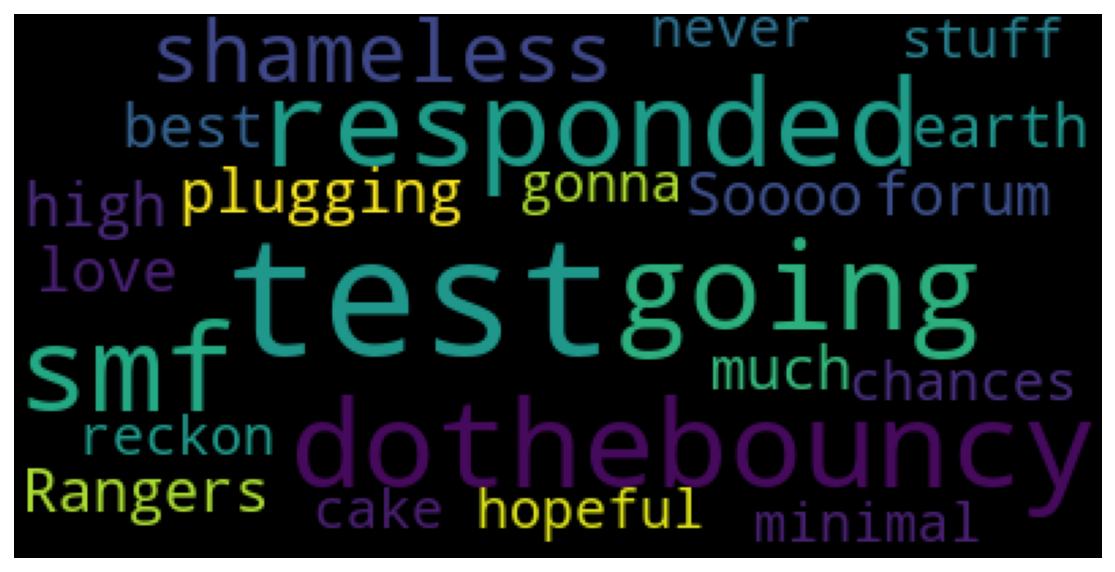

In [17]:
# Generate the Word Cloud for Neutral Sentiment.
plot_wordcloud(create_corpus("neutral", "text"))

In [18]:
""" How much 'selected_text' and 'text' feature matches with each other? """

# Relation between 'text' and 'selected_text' features.

x = []
y = []

same_cnt = 0
arr = []
sentences = []
length = train.shape[0]

for index, row in train.iterrows():
    first = row["text"].split()
    d = {}
    for j in first:
        if d.get(j):
            d[j] = d[j] + 1
        else:
            d[j] = 1

    cnt = 0
    scd = row["selected_text"].split()
    for j in scd:
        if d.get(j) != None and d[j] > 0:
            cnt += 1
            d[j] -= 1
    if cnt == len(scd):
        same_cnt += 1
    else:
        arr.append(round((cnt / float(len(scd))) * 100.0, 0))
        sentences.append([row["text"], row["selected_text"]])
    x.append(len(scd))
    y.append(cnt)

ss = round((same_cnt / float(train.shape[0])) * 100.0, 0)
mn = round(np.mean(arr), 0)

print("Almost {0}% of 'selected_text' are strict subset of 'text' feature.".format(ss))
print("\nOut of {0}% remaining 'selected_text', there is almost {1}% average match of 'selected_text' and 'text' feature.".format(100 - ss, mn))

Almost 89.0% of 'selected_text' are strict subset of 'text' feature.

Out of 11.0% remaining 'selected_text', there is almost 57.0% average match of 'selected_text' and 'text' feature.


# **Text Preprocessing & Cleaning.**

Function to clean the review text and remove all the unnecessary elements.

In [ ]:
# Text Preprocessing & Cleaning.

def clean_text(text):
    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    return text

def remove_stopword(x):
    return [y for y in x if y not in stopwords.words("english")]

"""
train['text'] = train['text'].apply(lambda x:remove_stopword(x))
train['selected_text'] = train['selected_text'].apply(lambda x:remove_stopword(x))

train['text'] = train['text'].apply(lambda x:clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x:clean_text(x))
"""

# **Building Text Extraction Model using Tensorflow RoBERTa.**

## **Tokenize Dataset.**

The first task is preparing the data. We are given "**text**", "**selected_text**", and "**sentiment**" features. For RoBERTa model, we prepare question answer as `<s> text </s></s> sentiment </s>`. Note that, the  RoBERTa tokenizer sometimes creates more than 1 token for 1 word. Let's take the example "Kaggle is a fun webplace!". The word "webplace" will be split into two tokens "[web][place]" by RoBERTa tokenizer.

After converting "**text**" and "**selected_text**" into tokens, we can then determine the start index and end index of "**selected_text**" within "**text**". We will one hot encode these indices. Below are the required inputs and targets for RoBERTa. In this example, we have chosen RoBERTa with `MAX_LEN = 16`, so the `input_ids` have two `<pad>` tokens.

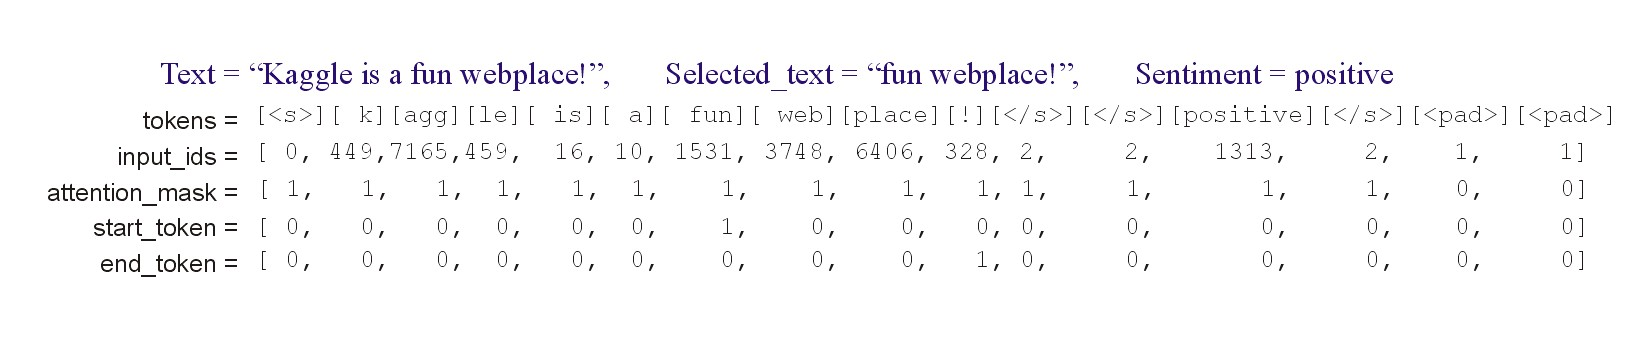

In [20]:
# Model Configuration.

MAX_LEN = 96

sentiment_id = {"positive": 1313, "negative": 2430, "neutral": 7974}

tokenizer = tokenizers.ByteLevelBPETokenizer(
    vocab="vocab-roberta-base.json",
    merges="merges-roberta-base.txt",
    lowercase=True,
    add_prefix_space=True,
)

""" Tokenize Training Data into arrays for the RoBERTa Model. """

input_ids = np.ones((train.shape[0], MAX_LEN), dtype="int32")
attention_mask = np.zeros((train.shape[0], MAX_LEN), dtype="int32")
token_type_ids = np.zeros((train.shape[0], MAX_LEN), dtype="int32")
start_tokens = np.zeros((train.shape[0], MAX_LEN), dtype="int32")
end_tokens = np.zeros((train.shape[0], MAX_LEN), dtype="int32")

for k in range(train.shape[0]):

    # FIND OVERLAP.
    text1 = " " + " ".join(train.loc[k, "text"].split())
    text2 = " ".join(train.loc[k, "selected_text"].split())
    idx = text1.find(text2)
    chars = np.zeros((len(text1)))
    chars[idx : idx + len(text2)] = 1
    if text1[idx - 1] == " ":
        chars[idx - 1] = 1
    enc = tokenizer.encode(text1)

    # ID_OFFSETS.
    offsets = []
    idx = 0
    for t in enc.ids:
        w = tokenizer.decode([t])
        offsets.append((idx, idx + len(w)))
        idx += len(w)

    # START END TOKENS.
    toks = []
    for i, (a, b) in enumerate(offsets):
        sm = np.sum(chars[a:b])
        if sm > 0:
            toks.append(i)

    s_tok = sentiment_id[train.loc[k, "sentiment"]]
    input_ids[k, : len(enc.ids) + 5] = [0] + enc.ids + [2, 2] + [s_tok] + [2]
    attention_mask[k, : len(enc.ids) + 5] = 1
    if len(toks) > 0:
        start_tokens[k, toks[0] + 1] = 1
        end_tokens[k, toks[-1] + 1] = 1


""" Tokenize Test Data into arrays for the RoBERTa Model. """

input_ids_t = np.ones((test.shape[0], MAX_LEN), dtype="int32")
attention_mask_t = np.zeros((test.shape[0], MAX_LEN), dtype="int32")
token_type_ids_t = np.zeros((test.shape[0], MAX_LEN), dtype="int32")

for k in range(test.shape[0]):

    # INPUT_IDS.
    text1 = " " + " ".join(test.loc[k, "text"].split())
    enc = tokenizer.encode(text1)
    s_tok = sentiment_id[test.loc[k, "sentiment"]]
    input_ids_t[k, : len(enc.ids) + 5] = [0] + enc.ids + [2, 2] + [s_tok] + [2]
    attention_mask_t[k, : len(enc.ids) + 5] = 1

## **Build the RoBERTa Model.**

HuggingFace does not have `TFRobertaForQuestionAnswering`, so we begin with vanilla `TFRobertaModel`.

We used a **pre-trained RoBERTa base model** and added a custom question answer head. The tokens `ids`, `att`, `tok` are the input into the `bert_model` and then we use BERT's first output, i.e., `x[0]` below. These are embeddings of all input tokens and have shapes `(BATCH_SIZE, MAX_LEN, 768)`. Next, we apply the `tf.keras.layers.Conv1D(filters=1, kernel_size=1)` and transform the embeddings into shape `(BATCH_SIZE, MAX_LEN, 1)`. We then flatten this and apply softmax activation, so the final output from `x1` has a shape of `(BATCH_SIZE, MAX_LEN)`. These are one-hot encodings of the start tokens indices (for "selected_text"), and `x2` is the end tokens indices. [[Reference]](https://www.kaggle.com/c/tweet-sentiment-extraction/discussion/143281)

![image.jpg](https://pic3.zhimg.com/80/v2-dcb83ca651acc1c93c9c8f982ee4b67e_1440w.jpg)

In [21]:
# Model Architecture/Pipeline.
def build_model():
    ids = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    att = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)
    tok = tf.keras.layers.Input((MAX_LEN,), dtype=tf.int32)

    config = RobertaConfig.from_pretrained("config-roberta-base.json")
    bert_model = TFRobertaModel.from_pretrained(
        "pretrained-roberta-base.h5", config=config
    )
    x = bert_model(ids, attention_mask=att, token_type_ids=tok)

    x1 = tf.keras.layers.Dropout(0.1)(x[0])
    x1 = tf.keras.layers.Conv1D(1, 1)(x1)
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Activation("softmax")(x1)

    x2 = tf.keras.layers.Dropout(0.1)(x[0])
    x2 = tf.keras.layers.Conv1D(1, 1)(x2)
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Activation("softmax")(x2)

    # Final Model Construction.
    model = tf.keras.models.Model(inputs=[ids, att, tok], outputs=[x1, x2])
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
    
    # Compile the Model.
    model.compile(loss="categorical_crossentropy", optimizer=optimizer)
    return model


# Evaluation Metric.
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if (len(a) == 0) & (len(b) == 0):
        return 0.5
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

## **Train the RoBERTa Model.**

In [22]:
jac = []
VER = "v0"
DISPLAY = 1
oof_start = np.zeros((input_ids.shape[0], MAX_LEN))
oof_end = np.zeros((input_ids.shape[0], MAX_LEN))
preds_start = np.zeros((input_ids_t.shape[0], MAX_LEN))
preds_end = np.zeros((input_ids_t.shape[0], MAX_LEN))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)

for fold, (idxT, idxV) in enumerate(skf.split(input_ids, train.sentiment.values)):

    print("=" * 30)
    print("-----> FOLD %i" % (fold + 1))
    print("=" * 30)

    K.clear_session()

    # Call the Model Architecture.
    model = build_model()

    sv = tf.keras.callbacks.ModelCheckpoint(
        "%s-roberta-%i.h5" % (VER, fold),
        monitor="val_loss",
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode="auto",
        save_freq="epoch",
    )

    # Fit the Model.
    model.fit(
        [input_ids[idxT,], attention_mask[idxT,], token_type_ids[idxT,]],
        [start_tokens[idxT,], end_tokens[idxT,]],
        epochs=3,
        batch_size=32,
        verbose=DISPLAY,
        callbacks=[sv],
        validation_data=(
            [input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]],
            [start_tokens[idxV,], end_tokens[idxV,]]
        )
    )

    print("\nLoading Model.....")
    model.load_weights('%s-roberta-%i.h5'%(VER,fold))

    print("Predicting OOF.....")
    oof_start[idxV,], oof_end[idxV,] = model.predict(
        [input_ids[idxV,], attention_mask[idxV,], token_type_ids[idxV,]], verbose=DISPLAY
    )

    print("Predicting Test.....")
    preds = model.predict(
        [input_ids_t, attention_mask_t, token_type_ids_t], verbose=DISPLAY
    )
    preds_start += preds[0] / skf.n_splits
    preds_end += preds[1] / skf.n_splits

    # DISPLAY FOLD JACCARD.
    all = []
    for k in idxV:
        a = np.argmax(oof_start[k,])
        b = np.argmax(oof_end[k,])
        if a > b:
            st = train.loc[k, "text"]
        else:
            text1 = " " + " ".join(train.loc[k, "text"].split())
            enc = tokenizer.encode(text1)
            st = tokenizer.decode(enc.ids[a - 1 : b])
        all.append(jaccard(st, train.loc[k, "selected_text"]))
    jac.append(np.mean(all))
    print(">>>>> FOLD %i Jaccard =" % (fold + 1), np.mean(all))
    print()

-----> FOLD 1


All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
687/687 [==============================] - ETA: 0s - loss: 2.2966 - activation_loss: 1.1114 - activation_1_loss: 1.1851
Epoch 1: val_loss improved from inf to 1.77250, saving model to v0-roberta-0.h5
687/687 [==============================] - 501s 707ms/step - loss: 2.2966 - activation_loss: 1.1114 - activation_1_loss: 1.1851 - val_loss: 1.7725 - val_activation_loss: 0.8885 - val_activation_1_loss: 0.8840
Epoch 2/3
687/687 [==============================] - ETA: 0s - loss: 1.6917 - activation_loss: 0.8626 - activation_1_loss: 0.8291
Epoch 2: val_loss improved from 1.77250 to 1.67731, saving model to v0-roberta-0.h5
687/687 [==============================] - 490s 714ms/step - loss: 1.6917 - activation_loss: 0.8626 - activation_1_loss: 0.8291 - val_loss: 1.6773 - val_activation_loss: 0.8704 - val_activation_1_loss: 0.8069
Epoch 3/3
687/687 [==============================] - ETA: 0s - loss: 1.5596 - activation_loss: 0.8041 - activation_1_loss: 0.7554
Epoch 3: val_loss improved f

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
688/688 [==============================] - ETA: 0s - loss: 2.2516 - activation_loss: 1.1207 - activation_1_loss: 1.1309
Epoch 1: val_loss improved from inf to 1.72673, saving model to v0-roberta-1.h5
688/688 [==============================] - 513s 723ms/step - loss: 2.2516 - activation_loss: 1.1207 - activation_1_loss: 1.1309 - val_loss: 1.7267 - val_activation_loss: 0.9035 - val_activation_1_loss: 0.8232
Epoch 2/3
688/688 [==============================] - ETA: 0s - loss: 1.7127 - activation_loss: 0.8764 - activation_1_loss: 0.8363
Epoch 2: val_loss improved from 1.72673 to 1.65160, saving model to v0-roberta-1.h5
688/688 [==============================] - 494s 718ms/step - loss: 1.7127 - activation_loss: 0.8764 - activation_1_loss: 0.8363 - val_loss: 1.6516 - val_activation_loss: 0.8330 - val_activation_1_loss: 0.8186
Epoch 3/3
688/688 [==============================] - ETA: 0s - loss: 1.5685 - activation_loss: 0.8025 - activation_1_loss: 0.7660
Epoch 3: val_loss did not im

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
688/688 [==============================] - ETA: 0s - loss: 2.1364 - activation_loss: 1.0542 - activation_1_loss: 1.0822
Epoch 1: val_loss improved from inf to 1.68543, saving model to v0-roberta-2.h5
688/688 [==============================] - 512s 721ms/step - loss: 2.1364 - activation_loss: 1.0542 - activation_1_loss: 1.0822 - val_loss: 1.6854 - val_activation_loss: 0.8571 - val_activation_1_loss: 0.8283
Epoch 2/3
688/688 [==============================] - ETA: 0s - loss: 1.6339 - activation_loss: 0.8435 - activation_1_loss: 0.7904
Epoch 2: val_loss improved from 1.68543 to 1.63772, saving model to v0-roberta-2.h5
688/688 [==============================] - 493s 717ms/step - loss: 1.6339 - activation_loss: 0.8435 - activation_1_loss: 0.7904 - val_loss: 1.6377 - val_activation_loss: 0.8392 - val_activation_1_loss: 0.7986
Epoch 3/3
688/688 [==============================] - ETA: 0s - loss: 1.4916 - activation_loss: 0.7708 - activation_1_loss: 0.7209
Epoch 3: val_loss improved f

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
688/688 [==============================] - ETA: 0s - loss: 2.1866 - activation_loss: 1.1018 - activation_1_loss: 1.0848
Epoch 1: val_loss improved from inf to 1.68482, saving model to v0-roberta-3.h5
688/688 [==============================] - 512s 721ms/step - loss: 2.1866 - activation_loss: 1.1018 - activation_1_loss: 1.0848 - val_loss: 1.6848 - val_activation_loss: 0.8654 - val_activation_1_loss: 0.8194
Epoch 2/3
688/688 [==============================] - ETA: 0s - loss: 1.6494 - activation_loss: 0.8558 - activation_1_loss: 0.7936
Epoch 2: val_loss improved from 1.68482 to 1.60425, saving model to v0-roberta-3.h5
688/688 [==============================] - 493s 716ms/step - loss: 1.6494 - activation_loss: 0.8558 - activation_1_loss: 0.7936 - val_loss: 1.6043 - val_activation_loss: 0.8155 - val_activation_1_loss: 0.7887
Epoch 3/3
688/688 [==============================] - ETA: 0s - loss: 1.4904 - activation_loss: 0.7727 - activation_1_loss: 0.7177
Epoch 3: val_loss did not im

All model checkpoint layers were used when initializing TFRobertaModel.

All the layers of TFRobertaModel were initialized from the model checkpoint at pretrained-roberta-base.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Epoch 1/3
688/688 [==============================] - ETA: 0s - loss: 2.1606 - activation_loss: 1.0646 - activation_1_loss: 1.0960
Epoch 1: val_loss improved from inf to 1.66096, saving model to v0-roberta-4.h5
688/688 [==============================] - 512s 721ms/step - loss: 2.1606 - activation_loss: 1.0646 - activation_1_loss: 1.0960 - val_loss: 1.6610 - val_activation_loss: 0.8701 - val_activation_1_loss: 0.7909
Epoch 2/3
688/688 [==============================] - ETA: 0s - loss: 1.6724 - activation_loss: 0.8527 - activation_1_loss: 0.8197
Epoch 2: val_loss improved from 1.66096 to 1.63545, saving model to v0-roberta-4.h5
688/688 [==============================] - 493s 716ms/step - loss: 1.6724 - activation_loss: 0.8527 - activation_1_loss: 0.8197 - val_loss: 1.6355 - val_activation_loss: 0.8460 - val_activation_1_loss: 0.7895
Epoch 3/3
688/688 [==============================] - ETA: 0s - loss: 1.5144 - activation_loss: 0.7780 - activation_1_loss: 0.7365
Epoch 3: val_loss did not im

In [23]:
print(">>>>> OVERALL 5-Fold CV Jaccard =", np.mean(jac))

>>>>> OVERALL 5-Fold CV Jaccard = 0.701276454467354


# **Kaggle Submission.**

In [24]:
all = []
for k in range(input_ids_t.shape[0]):
    a = np.argmax(preds_start[k,])
    b = np.argmax(preds_end[k,])
    if a > b:
        st = test.loc[k, "text"]
    else:
        text1 = " " + " ".join(test.loc[k, "text"].split())
        enc = tokenizer.encode(text1)
        st = tokenizer.decode(enc.ids[a - 1 : b])
    all.append(st)

test["selected_text"] = all
test[["textID", "selected_text"]].to_csv("submission.csv", index=False)
pd.set_option("max_colwidth", 60)
test.sample(25)

,textID,text,sentiment,selected_text
2370,225e7973da,follow me??,neutral,follow me??
2842,6e0abe59f9,now i`m done! good nite,positive,good nite
1126,dc4fa42628,"That`s not what said I like you, too, though. is goi...",neutral,"that`s not what said i like you, too, though. is going ..."
291,086671fad9,ok. lol. i miss you too. i hope your cramps get better....,neutral,ok. lol. i miss you too. i hope your cramps get better....
1390,e108bb4fa1,I woke up this morning thinking it is Saturday,neutral,i woke up this morning thinking it is saturday
559,e43b9a1497,"I love my mom! Happy Mother`s Day, mommies",positive,i love
1355,7c229b34c1,_Itx no credits for me unfortunately!,negative,unfortunately!
3256,1d5318a66f,Listening to Jesse`s music & on MySpace. Also getting t...,neutral,listening to jesse`s music & on myspace. also getting t...
2787,0aec5ff9a0,is *ugh* what a miserable looking day. 54 degrees. Where...,negative,miserable
830,2942ed51f6,"Not so much a substitute as a variation. Ate too much, ...",neutral,"not so much a substitute as a variation. ate too much, ..."
